We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add StochasticBarriers folder to current working path
sys.path.append(parent_directory+"/demos/StochasticBarriers")

# Overview

We extract elliptic Lagrangian stochastic barriers in the Agulhas region from the AVISO dataset using the null geodesic identification scheme. All the results on diffusive scalar transport in a deterministic velocity field carry over automatically to particle transport in the stochastic velocity given by: 

\begin{equation}
d \mathbf{x}(t) = \mathbf{v}(\mathbf{x}(t), t)dt +  \sqrt{\nu} \mathbf{B}(\mathbf{x}(t), t)d\mathbf{W}(t),
\label{eq: ProbabilisticTransport} \tag{1}
\end{equation}

where $ \mathbf{x}(t) \in \mathbb{R}^n $ is the random position vector of a particle at time $ t $; $ \mathbf{v}(\mathbf{x}, t) $ denotes the incompressible, deterministic drift in the particle motion; and $ \mathbf{W}(t) $ is an m-dimensional Wiener process with diffusion matrix $ \sqrt{\nu} \mathbf{B}(\mathbf{x}(t), t) $. Elliptic Lagrangian stochastic barriers are sharp barriers to particle transport under uncertainties in the velocity field. As higlighted in [1], for probabilistic diffusion barriers in the stochastic velocity field, we can apply the same procedure from the [Lagrangian diffusion barriers](../../DiffusionBarriers/EllipticLagrangianDiffusionBarriers/Main/EllipticLagrangianDiffusionBarriersAgulhas.ipynb) by setting:

\begin{equation}
\mathbf{D}(\mathbf{x}, t) = \dfrac{1}{2} \mathbf{B}(\mathbf{x}, t)\mathbf{B}(\mathbf{x}, t)^T \tag{2}
\end{equation}

The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
2. Define computational parameters (such as the number of cores) and data.
3. Define spatio-temporal domain.
4. Interpolate velocity from the (discrete) gridded data.
5. Elliptic Lagrangian stochastic barriers (LSB):

    Define $ \mathbf{B}(\mathbf{x}(t), t) $:
    
    \begin{equation}
    \mathbf{B}(\mathbf{x}, t) = \begin{pmatrix} \sqrt{2} && 0 \\ 0 && \sqrt{2} \end{pmatrix} \tag{3}
    \end{equation}    
    
    and
        
    \begin{equation}
    \mathbf{D}(\mathbf{x}, t) = \dfrac{1}{2}\mathbf{B}(\mathbf{x}, t)\mathbf{B}(\mathbf{x}, t)^T \tag{4}
    \end{equation}
    
    Follow the same procedure from the [Lagrangian diffusion barriers](../../DiffusionBarriers/EllipticLagrangianDiffusionBarriers/Main/EllipticLagrangianDiffusionBarriersAgulhas.ipynb)
 <br />    
6. Lagrangian stochastic simulation:

    In order to verify that the ring boundaries (computed from the deterministic velocity field) in step [5] act as sharp barriers to particle transport under uncertainties we perfom a Monte-Carlo simulation of eq. \ref{eq: ProbabilisticTransport} in the Lagrangian frame:
    
    \begin{equation}
    d \mathbf{x}_0(t) = \sqrt{\nu} \mathbf{B}_0(\mathbf{x}(t), t) d\mathbf{W}(t), \quad \mathbf{B}_0(\mathbf{x}(t), t) = \mathbf{\nabla F_{t_0}^t}^{-1} \mathbf{B}(\mathbf{x}(t), t)
    \label{eq: LagrangianProbabilisticTransport} \tag{5}
    \end{equation}

    First we find the outermost elliptic stochastic barriers within each family of elliptic SDB computed in step [5].

    Then we seed inside the outermost elliptic stochastic barriers particles and advect them using equation \ref{eq: LagrangianProbabilisticTransport} over the time-interval $ [t_0, t_N] $.
     
7. References

# Import data

We start by importing the AVISO-data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 6

# Time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

# Defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## Meshgrid
X, Y = np.meshgrid(x, y)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 50

# Rime step-size
dt = .1

# Time resolution: N = len(time)
time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# domain boundary (in degrees)
xmin = -3.5
xmax = 1
ymin = -32
ymax = -28

# make sure that the spatio-temporal you defined are within the domain of the data
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

# NOTE: As we are computing spatial derivatives of the CG-tensor, the spacing of the meshgrid has to be sufficiently small.
# However, choosing dx to be too small leads to (unnecessary) long computation times.

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Ny = X_domain.shape[0]
Nx = X_domain.shape[1]

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/5, 1/10]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy]

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0]
Interpolant_v = Interpolant[1]

  0%|          | 0/92 [00:00<?, ?it/s]

# Elliptic Lagrangian stochastic barriers

##  Time averaged diffusion Cauchy Green (CG) strain tensor

Next, we compute the time-averaged diffusion Cauchy Green strain tensor $ \mathrm{\overline{C}_{D}}_{t_0}^{t_N}(\mathbf{x}_0) $ over the time-interval $ [t_0, t_N] $ by iterating over a meshgrid (parallelized). 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid when computing spatial derivatives.

In [6]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to compute gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute diffusive Cauchy Green strain tensor
from ipynb.fs.defs.DiffusionCauchyGreen import DiffusionCauchyGreen

# Import RegularGridInterpolator
from scipy.interpolate import RegularGridInterpolator

# split x0, y0 into 'Ncores' (equal) batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_CD(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch])
    
    # Compute trajectories
    Fmap = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0] # shape (N, 2, Nx*Ny)
    
    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # shape (N, 2, 2, Nx*Ny)
    
    # compute CG
    Cd_avg = gradFmap[0,:,:,:].copy()*np.nan # shape (2, 2, Nx*Ny)
    
    DBS_parallel = []
    
    for i in range(gradFmap.shape[3]):
        Cd_avg[:,:,i] = DiffusionCauchyGreen(Interpolant_D11, Interpolant_D12, Interpolant_D22, time, Fmap[:,:,i], gradFmap[:,:,:,i], lenT, n_averaging) # shape (2, 2, Nx*Ny)

    return Cd_avg

In [7]:
# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel()
y0 = Y_domain.ravel()

x0_batch = list(split(x0, Ncores))
y0_batch = list(split(y0, Ncores))

# number of diffusive Cauchy Green strain tensor used for averaging
n_averaging = 10

# Components of diffusivity tensor D11, D12, D22 over spatial meshgrid and time have shape (Ny, Nx, N)
# , where Ny/Nx are the spatial resolution in the lat/long coordinates
# and N the time-resolution of the data
D11_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))
D12_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))
D22_field = np.zeros((X.shape[0], Y.shape[1], time_data.shape[1]))

# Diffusion matrix D = 1/2*BB^Twe set it to be constant in space and time 
# but it can generally be spatially and temporally varying).
B11 = np.sqrt(2)
B12 = 0
B21 = 0
B22 = np.sqrt(2)

# D = 1/2*B*B^T
D11_field[:,:,:] = 1/2*(B11**2+B12**2)
D12_field[:,:,:] = 1/2*(B11*B12+B22*B12)
D22_field[:,:,:] = 1/2*(B12**2+B22**2)
# Interpolate D11_field/D12_field/D22_field over spatial and temporal domain
Interpolant_D11 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D11_field)
Interpolant_D12 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D12_field)
Interpolant_D22 = RegularGridInterpolator((Y[:,0], X[0,:], time_data[0,:]), D22_field)
    
# Compute DBS with parallel computing
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_CD)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# extract averaged CG tensor from results of parallel computing
CD = results[0]

for res in results[1:]:
    CD = np.append(CD, res, axis = 2)
    
# reshape array from vectorized form to structured meshgrid
CD = CD.reshape((2, 2, X_domain.shape[0], X_domain.shape[1]))

### Note that this step here is optional
# In order to suppress numerical noise arising from the computations of derivatives of the rate of strain tensor,
# we can apply a spatial average filter on the rate of strain tensor

# kernel_size of spatial average filter
kernel_size = 1

def filter_CauchyGreenStrain(C):
    
    C_filter = C.copy()
    
    for i in range(C.shape[2]):
        for ii in range(C.shape[3]):
            kernel_size_low_y = max(i-kernel_size, 0)
            kernel_size_up_y = min(i+kernel_size+1, Ny)
            kernel_size_low_x = max(ii-kernel_size, 0)
            kernel_size_up_x = min(ii+kernel_size+1, Nx)
            if len(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel()) > 0:
                C_filter[0,0,i,ii] = np.nanmean(C[0,0,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[0,1,i,ii] = np.nanmean(C[0,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
                C_filter[1,0,i,ii] = C[0,1,i,ii]
                C_filter[1,1,i,ii] = np.nanmean(C[1,1,kernel_size_low_y:kernel_size_up_y, kernel_size_low_x:kernel_size_up_x].ravel())
    return C_filter
            
CD = filter_CauchyGreenStrain(CD.copy())

## Interpolate diffusion averaged Cauchy-Green strain tensor

In [8]:
# Import RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS

# Compute elements of CG tensor
CD11 = CD[0,0,:,:].copy()
CD12 = CD[0,1,:,:].copy()
CD22 = CD[1,1,:,:].copy()
    
# Interpolate elements of CG tensor (per default: linear)
interp_CD11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD11, nan=0.0), kx = 1, ky = 1)
interp_CD12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD12, nan=0.0), kx = 1, ky = 1)
interp_CD22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(CD22, nan=0.0), kx = 1, ky = 1)

# Initialize arrays
CD11x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD11y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD12x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD12y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD22x = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
CD22y = np.zeros((CD11.shape[0], CD11.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        CD11x[i, j] = (interp_CD11(x[1], x[0]+rho_x)[0][0]-interp_CD11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD11y[i, j] = (interp_CD11(x[1]+rho_y, x[0])[0][0]-interp_CD11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        CD12x[i, j] = (interp_CD12(x[1], x[0]+rho_x)[0][0]-interp_CD12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD12y[i, j] = (interp_CD12(x[1]+rho_y, x[0])[0][0]-interp_CD12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        CD22x[i, j] = (interp_CD22(x[1], x[0]+rho_x)[0][0]-interp_CD22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        CD22y[i, j] = (interp_CD22(x[1]+rho_y, x[0])[0][0]-interp_CD22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

## Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [9]:
# import function to compute interpolant of phi_prime
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_phi_prime_denom = _phi_prime(X_domain, Y_domain, CD11, CD12, CD22, CD11x, CD11y, CD12x, CD12y, CD22x, CD22y)

## Compute elliptic Lagrangian stochastic barriers

In [10]:
# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# Define T0 range
T0_min = .8
T0_max = 1.2
n_T0 = 2*Ncores
T0_range = np.linspace(T0_min, T0_max, n_T0)

# Threshold distance between starting and return point of trajectory
d_threshold = dx/2

# compute elliptic SB
def compute_elliptic_SB(T0):
    
    # Define list storing x, y coordinates of elliptic LCS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_T0 = closed_null_geodesics(X_domain, Y_domain, T0, interp_phi_prime, interp_phi_prime_denom, d_threshold, CD11, verbose=True)
    
    x_elliptic, y_elliptic = [], []
    
    # Iterate over all geodesics
    for NG in closed_NG:
        
        if np.sum(NG[0]) is not None:
            
            x = NG[0]
            y = NG[1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            
            x_elliptic.append(x)
            y_elliptic.append(y)
        
    return [x_elliptic, y_elliptic, init_T0]
        
# compute elliptic SB with parallel computing
Elliptic_SB = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_elliptic_SB)(i) for i in T0_range)

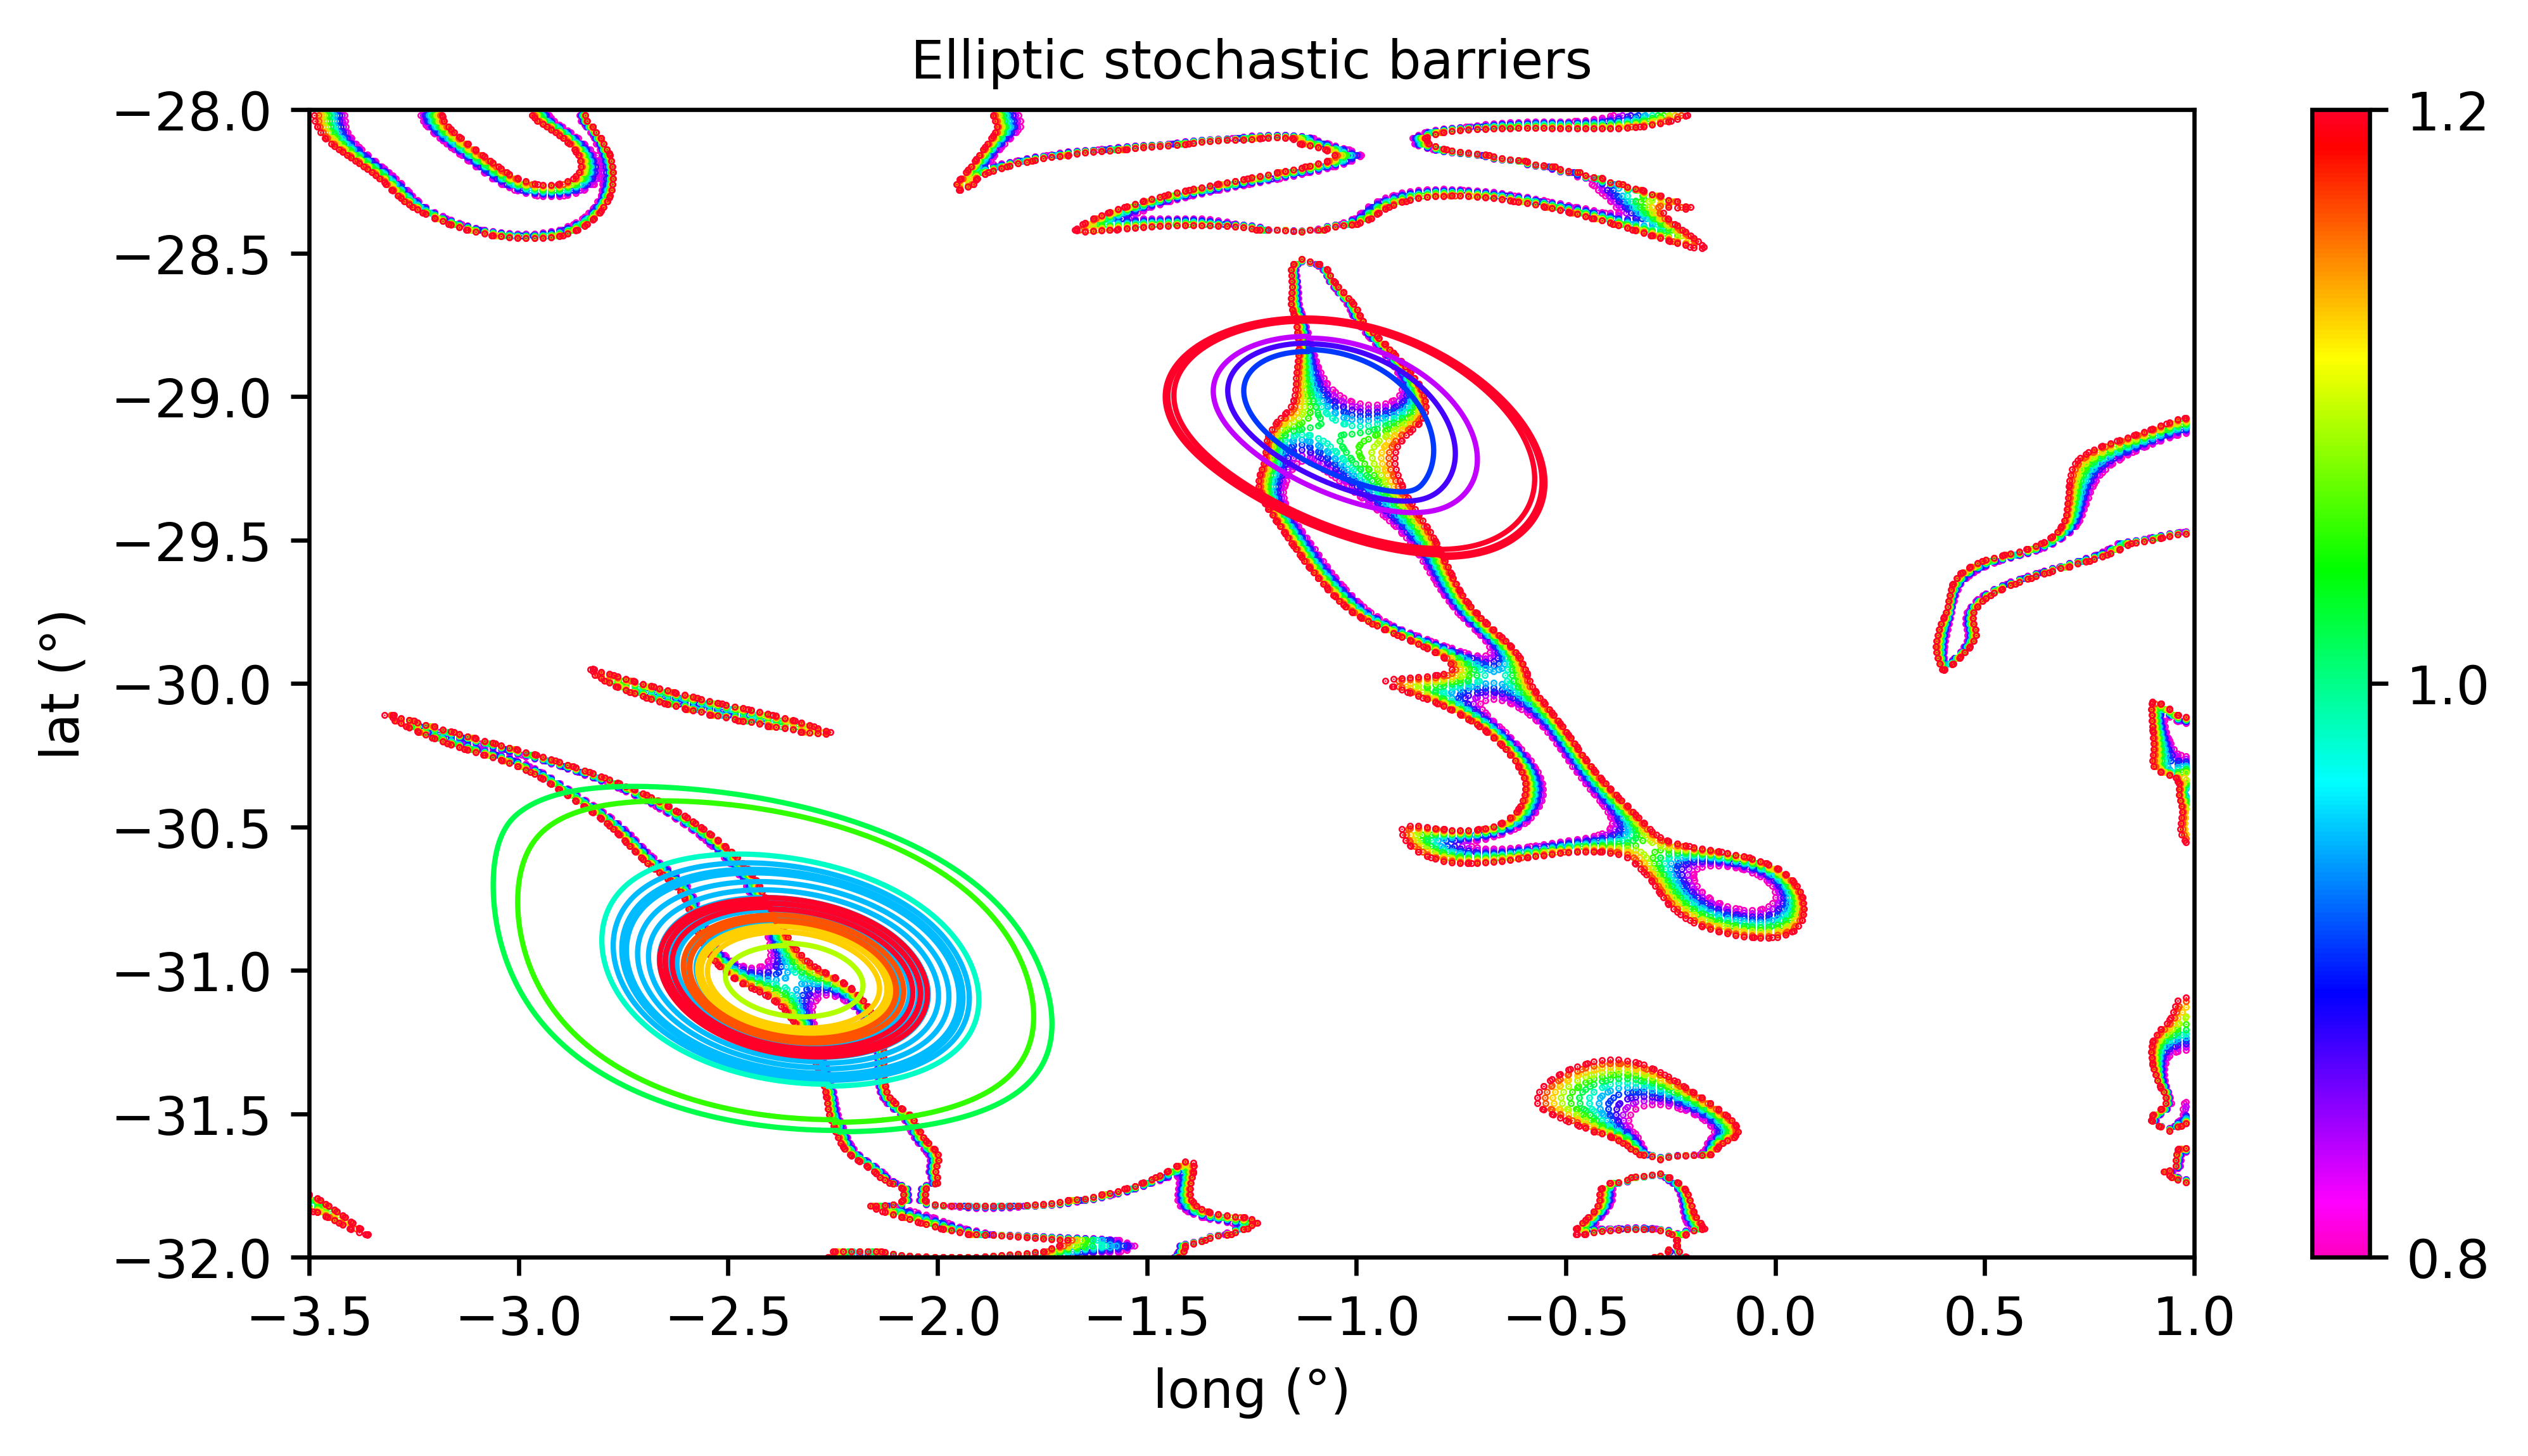

In [11]:
############################################ PLOT RESULTS ############################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T0_range.min(), vmax=T0_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic SB and plot
for i in range(len(Elliptic_SB)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_SB[i][2][0], Elliptic_SB[i][2][1], color=cmap.to_rgba(T0_range[i]), s = 0.1)
    
    # Plot elliptic SB
    if Elliptic_SB[i][0] is not None:
        for j in range(len(Elliptic_SB[i][0])):
            if Elliptic_SB[i][0][j] is not None:
                ax.plot(Elliptic_SB[i][0][j], Elliptic_SB[i][1][j], c=cmap.to_rgba(T0_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[T0_range.min(), 1, T0_range.max()])

# Title
ax.set_title("Elliptic stochastic barriers", fontsize = 10)
plt.show();

The colored (closed) curves indicate elliptic Lagrangian diffusion barriers with constant transport density $ \mathcal{T}_0 $. The colored dots indicate the initial conditions depending on $ \mathcal{T}_0 $.

# Lagrangian stochastic simulation

We proceed by extracting the outermost elliptic barriers computed in step [5]. We then seed particles inside those barriers and advect them according to equation \ref{eq: LagrangianProbabilisticTransport}

## Find outermost closed curve for each family of elliptic Lagrangian stochastic barriers

We now seek to find the outermost elliptic SDB within each family of SDBs.

In [12]:
# import function which extracts outermost elliptic SB for each family of elliptic SB
from ipynb.fs.defs.find_outermost_closed_curve import find_outermost_closed_curve

# find outermost elliptic SB in each family of elliptic SB
x_outermost_elliptic_SB, y_outermost_elliptic_SB, T0_outermost_elliptic_SB = find_outermost_closed_curve(Elliptic_SB, T0_range)

## Compute stochastic trajectories in Lagrangian frame

We now compute the stochastic trajectories by first evaluating $ \mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0) $ over $ t \in [t_0, t_N] $. The stochastic trajectories are computed using itoSRI2 (Rößler2010 order 1.0 strong Stochastic Runge-Kutta algorithm SRI2) from [sdeint](https://pypi.org/project/sdeint/). The particles are seeded inside the outermost closed stochastic barriers extracted from the deterministic velocity field. For comparison, we also seed particles inside shifted copies of the closed stochastic barriers.

### Compute $ \mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0), \quad t \in [t_0, t_N] $

In [13]:
# Import shapely library to create polygons and points
from shapely.geometry import Polygon, Point

# Import function to suppress printing
from IPython.utils import io

# define B
B = np.array([[B11, B12], [B21, B22]])

# define \nu
nu = 10**(-6)

x0_stochastic, y0_stochastic = [], []
x_shifted, y_shifted = [], []
c = []

# number of stochastic particles per initial condition seeded inside the closed barriers
N_stochastic_particles = 8

# compute initial conditions for particles inside elliptic stochastic barrier and shifted version of elliptic_SD
for b in range(len(x_outermost_elliptic_SB)):
    
    Poly_object = Polygon(zip(x_outermost_elliptic_SB[b], y_outermost_elliptic_SB[b]))
    
    # shifte copy of outermost elliptic SB
    x_shifted.append(x_outermost_elliptic_SB[b]+3)
    y_shifted.append(y_outermost_elliptic_SB[b])
    
    for xi in np.arange(xmin, xmax, 0.075):
        
        for yi in np.arange(ymin, ymax, 0.075):
            
            if Poly_object.contains(Point(xi, yi)):
                
                # particles inside outermost elliptic stochastic barrier
                for _ in range(N_stochastic_particles):
                    
                    x0_stochastic.append(xi)
                    y0_stochastic.append(yi)
                    c.append(.75)
                
                # particles inside shifted version of outermost elliptic stochastic barrier (shifted by +3 in the x-direction)
                for _ in range(N_stochastic_particles):
                    
                    x0_stochastic.append(xi+3)
                    y0_stochastic.append(yi)
                    c.append(0)
                    
# Compute gradient of flow map
# This operation could also be parallelized
X0 = np.array([x0_stochastic, y0_stochastic])  

# Compute gradient of flowmap
with io.capture_output() as captured:
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid)

### Compute stochastic trajectories from  $ \mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0), \quad t \in [t_0, t_N] $ 

In [14]:
# import package for stochastic differential equations
import sdeint

# import spline interpolation for 1D
from scipy.interpolate import InterpolatedUnivariateSpline

def stochastic_trajectories(gradFmap, x0batch, y0batch):
    
    # closure function. This is just a dummy function needed to pass arguments to sdeint.
    def close(func, *args):
        def newfunc(x, t):
            return func(x, t, *args)
        return newfunc
    
    # drift term of ODE
    def f(x, t, gradFmap11, gradFmap12, gradFmap21, gradFmap22, B, nu):
        return np.array([0, 0])

    # stochastic term of ODE
    def G(x, t, gradFmap11, gradFmap12, gradFmap21, gradFmap22, B, nu):
                    
        gFmap11 = gradFmap11(t)
        gFmap12 = gradFmap12(t)
        gFmap21 = gradFmap21(t)
        gFmap22 = gradFmap22(t)
        
        inverse_gradFmap = 1/(gFmap11*gFmap22-gFmap12*gFmap21)*np.array([[gFmap22, -gFmap12], [-gFmap21, gFmap11]])
        
        B0 = np.sqrt(nu)*inverse_gradFmap@B
                    
        return B0
    
    x_stochastic, y_stochastic = [], []
    
    # Iterate over all initial conditions
    for j in range(len(x0batch)):
                
        X0 = np.array([x0batch[j], y0batch[j]])  
          
        gradFmap11 = InterpolatedUnivariateSpline(time, gradFmap[:,0,0,j])
        gradFmap12 = InterpolatedUnivariateSpline(time, gradFmap[:,0,1,j])
        gradFmap21 = InterpolatedUnivariateSpline(time, gradFmap[:,1,0,j])
        gradFmap22 = InterpolatedUnivariateSpline(time, gradFmap[:,1,1,j])
        
        if np.isfinite(np.sum(gradFmap[:,:,:].ravel())):
            args = (gradFmap11, gradFmap12, gradFmap21, gradFmap22, B, nu)
            result = sdeint.itoSRI2(close(f, *args), close(G, *args), X0, time)
            x_stochastic.append(result[:,0])
            y_stochastic.append(result[:,1])
                
        else:
                
            x_stochastic.append(np.zeros((len(time), ))*np.nan)
            y_stochastic.append(np.zeros((len(time), ))*np.nan)
    
    return x_stochastic, y_stochastic

gradFmap_batch = np.array_split(gradFmap, Ncores, axis = -1)
x0_batch = np.array_split(x0_stochastic, Ncores)
y0_batch = np.array_split(y0_stochastic, Ncores)

# compute stochastic particle trajectories inside outermost elliptic SB
Stochastic_trajectories = Parallel(n_jobs=Ncores)(delayed(stochastic_trajectories)(gradFmap_batch[i], x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

In [ ]:
############################################ PLOT RESULTS ############################################

# import animation library
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# transform stochastic trajectories from list object to a 2D array
x_traj = []
y_traj = []
for traj in Stochastic_trajectories:
    for idx in range(len(traj[0])):
        x_traj.append(traj[0][idx])
        y_traj.append(traj[1][idx])
        
x_traj = np.array(x_traj)
y_traj = np.array(y_traj)
c = np.array(c)

# initialize figure
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Set axis limits
ax.set_xlim([np.min(x_traj[:,0])-.5, np.max(x_traj[:,0])+.5])
ax.set_ylim([np.min(y_traj[:,0])-.5, np.max(y_traj[:,0])+.5])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# plot vortex boundaries
for i in range(len(x_outermost_elliptic_SB)):
    line, = ax.plot(x_outermost_elliptic_SB[i], y_outermost_elliptic_SB[i], c = "k", linewidth = 2)
    
# plot random closed curves
for i in range(len(x_shifted)):
    line, = ax.plot(x_shifted[i], y_shifted[i], '--', c = "k", linewidth = 2)
    
# initialize plot
scat = ax.scatter([], [])

label = ax.text(-2.5, -28.5, "Elapsed time: " + str(np.around(time[0], 2)) + "d", ha='center', va='center', fontsize=10, color="k")

def animate(frame):
    
    # update plot
    scat.set_offsets(np.column_stack([x_traj[:,5*frame].ravel(), y_traj[:,5*frame].ravel()]))
    scat.set_sizes(np.ones((c.shape[0], ))) # add size
    scat.set_array(c) # add colors
    scat.set_cmap('rainbow')
    label.set_text("Elapsed time: " + str(np.around(time[5*frame], 2)) + "d")
    
anim = FuncAnimation(fig, animate, frames = int(len(time)/5)+1, interval = 40, blit=False)
video = anim.to_html5_video()
html = display.HTML(anim.to_jshtml())
display.display(html)
plt.close()

The above figure displays the final positions of stochastic trajectories in the Lagrangian frame, initialized from the interiors of the closed black lines.

The trajectories released from inside the elliptic Lagrangian stochastic barriers (red) remain confined within the stochastic barriers over the time-interval $ [t_0, t_N] $. Trajectories released from a shifted version of the elliptic stochastic barriers (violet) are more likely to penetrate the closed curves and exhibit a less coherent behaviour. The difference becomes even more evident by increasing the number of particles seeded inside the closed barriers (The execution time of the demos becomes considerably longer though).

# References

[1] Haller, G., Karrasch, D., & Kogelbauer, F. (2018). Material barriers to diffusive and stochastic transport. Proceedings of the National Academy of Sciences, 115(37), 9074-9079.

[2] Notebook 8.4. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[3] [YouTube Tutorial](https://youtu.be/cRM2j-wx4kM)